### 寻找关键用户

#### 初始数据
- 用户用 `users` 列表存储。
- 朋友关系用元组的形式存储：对应两人 `id` ，存储在列表中。

In [1]:
users = [
    {"id": 0, "name": "Hero"},
    {"id": 1, "name": "Dunn"},
    {"id": 2, "name": "Sue"},
    {"id": 3, "name": "Chi"},
    {"id": 4, "name": "Thor"},
    {"id": 5, "name": "Clive"},
    {"id": 6, "name": "Hicks"},
    {"id": 7, "name": "Devin"},
    {"id": 8, "name": "Kate"},
    {"id": 9, "name": "Klein"}
]

friendship_pairs = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4),
                    (4, 5), (5, 6), (5, 7), (6, 8), (7, 8), (8, 9)]

用户关系网络可以画成图的形式：

![image](https://github.com/X-lab2017/dase-2023-autumn/assets/50283262/b0331f38-df31-4969-bcbf-dd1492b20051)

> **Tips** <br><br>
> 也可以通过*邻接矩阵*的方法表示用户关系网络

#### 用字典表示用户关系
- friendship_pairs 的形式表示朋友关系不是最简单的表示方法。如果我想查询用户1的朋友，需要遍历所有的元组才能得到结果。

In [2]:
# 初始化一个以用户id为键，以用户好友列表为值的字典
friendships = {user["id"]: [] for user in users}

friendships

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

In [3]:
# 循环表示朋友关系的元组对，抽取每个元组对中的两个元素，将其分别添加到字典中对应的值列表中
for i, j in friendship_pairs:
    friendships[i].append(j)  # 将 j 添加为用户 i 的朋友
    friendships[j].append(i)  # 将 i 添加为用户 j 的朋友

friendships

{0: [1, 2],
 1: [0, 2, 3],
 2: [0, 1, 3],
 3: [1, 2, 4],
 4: [3, 5],
 5: [4, 6, 7],
 6: [5, 8],
 7: [5, 8],
 8: [6, 7, 9],
 9: [8]}

当拥有了 `friendships` 后，我们可以快速知道用户的朋友是谁，也可以想对应的统计量并且求出具体数值。

#### 统计量场景1: 用户平均朋友数量

In [4]:
# 每个用户平均有多少个朋友?
def number_of_friends(user):
    """这个用户有多少朋友?"""
    user_id = user["id"]
    friend_ids = friendships[user_id]
    return len(friend_ids)


total_connections = sum(number_of_friends(user)
                        for user in users)        # 24

total_connections

24

In [5]:
# 除以用户数量
num_users = len(users)                            # 用户列表的长度
avg_connections = total_connections / num_users   # 24 / 10 == 2.4

print(num_users)
print(avg_connections)

10
2.4


#### 统计量场景2: 如何找到有最多朋友的用户

直观的想法是 将用户朋友数量从多到少排序

In [6]:
# 创建一个列表 (user_id, number_of_friends)
num_friends_by_id = [(user["id"], number_of_friends(user))
                     for user in users]

# 按照朋友数量进行排序
num_friends_by_id.sort(                                
    key=lambda id_and_friends: id_and_friends[1],      
    reverse=True)                                   

# Each pair is (user_id, num_friends):
# [(1, 3), (2, 3), (3, 3), (5, 3), (8, 3),
#  (0, 2), (4, 2), (6, 2), (7, 2), (9, 1)]

num_friends_by_id

[(1, 3),
 (2, 3),
 (3, 3),
 (5, 3),
 (8, 3),
 (0, 2),
 (4, 2),
 (6, 2),
 (7, 2),
 (9, 1)]

#### 另一个角度思考关键用户：度中心性

![image](https://github.com/X-lab2017/dase-2023-autumn/assets/50283262/b24fc233-d5f0-4063-84f8-8d87fe9d9251)

- 1和4哪个更加重要呢？
- 如果我结交了更优秀的人，是不是证明我也是相对优秀的人呢？

### 如何认识新朋友？

#### 发现朋友的朋友

In [7]:
def foaf_ids_bad(user):
    """foaf 是"friend of a friend"的缩写 """
    return [foaf_id
            for friend_id in friendships[user["id"]]
            for foaf_id in friendships[friend_id]]

foaf_ids_bad(users[0]) # [0, 2, 3, 0, 1, 3]

[0, 2, 3, 0, 1, 3]

In [8]:
# 相当于是将以下的三个输出串在一起～
print(friendships[0])  # [1, 2]
print(friendships[1])  # [0, 2, 3]
print(friendships[2])  # [0, 1, 3]

[1, 2]
[0, 2, 3]
[0, 1, 3]


发现这样的方式会出现 **自己** 或者出现已经是 **自己朋友的人** ，能否更加精简呢？

#### 准确地寻找朋友的朋友

In [9]:
from collections import Counter                   # 需要导入 collections 模块


def friends_of_friends(user):
    user_id = user["id"]
    return Counter(
        foaf_id
        for friend_id in friendships[user_id]     # 对于我的每个朋友，
        for foaf_id in friendships[friend_id]     # 计算他们的朋友，
        if foaf_id != user_id                     # 如果这个人，不是我
        and foaf_id not in friendships[user_id]   # 也不是我的朋友，那么就是我可以认识的人！
    )


print(friends_of_friends(users[3]))               # Counter({0: 2, 5: 1})

# 这个结果表示 id 为 3 的用户与 id 为 0 的用户，有两个共同好友；而与 id 为 5 的用户，有一个共同好友。

Counter({0: 2, 5: 1})


### 通过兴趣交朋友

#### 初始数据
- 每个元素都是成对的数据 (user_id,interest)

In [10]:
interests = [
    (0, "Hadoop"), (0, "Big Data"), (0, "HBase"), (0, "Java"),
    (0, "Spark"), (0, "Storm"), (0, "Cassandra"),
    (1, "NoSQL"), (1, "MongoDB"), (1, "Cassandra"), (1, "HBase"),
    (1, "Postgres"), (2, "Python"), (2, "scikit-learn"), (2, "scipy"),
    (2, "numpy"), (2, "statsmodels"), (2, "pandas"), (3, "R"), (3, "Python"),
    (3, "statistics"), (3, "regression"), (3, "probability"),
    (4, "machine learning"), (4, "regression"), (4, "decision trees"),
    (4, "libsvm"), (5, "Python"), (5, "R"), (5, "Java"), (5, "C++"),
    (5, "Haskell"), (5, "programming languages"), (6, "statistics"),
    (6, "probability"), (6, "mathematics"), (6, "theory"),
    (7, "machine learning"), (7, "scikit-learn"), (7, "Mahout"),
    (7, "neural networks"), (8, "neural networks"), (8, "deep learning"),
    (8, "Big Data"), (8, "artificial intelligence"), (9, "Hadoop"),
    (9, "Java"), (9, "MapReduce"), (9, "Big Data")
]

##### 简单概览
- id 为 0 的人和 id 为 9 的人在朋友关系图里并没有关联，但是他们都对 Java 和大数据很感兴趣！

#### 查找特定兴趣的人

In [11]:
def data_scientists_who_like(target_interest):
    """找到有着某种特定兴趣的所有用户的 ids"""
    return [user_id
            for user_id, user_interest in interests
            if user_interest == target_interest]

# 这个方法的缺点是，每次都要遍历整个列表，这样会很慢。

In [12]:
# 为了更快地找到与某种特定兴趣相同的用户，我们需要一个从兴趣到用户的反向映射（索引）。
from collections import defaultdict

# 键是兴趣，值是对这个兴趣感兴趣的用户 id 列表
user_ids_by_interest = defaultdict(list)

for user_id, interest in interests:
    user_ids_by_interest[interest].append(user_id)

# 键是用户 id，值是用户感兴趣的兴趣列表
interests_by_user_id = defaultdict(list)

for user_id, interest in interests:
    interests_by_user_id[user_id].append(interest)

因此就可以很容易找到与给定用户拥有最多共同兴趣的用户

In [13]:
def most_common_interests_with(user):
    return Counter(
        interested_user_id
        for interest in interests_by_user_id[user["id"]]
        for interested_user_id in user_ids_by_interest[interest]
        if interested_user_id != user["id"]
    )

### 工资和工作年限

#### 初始数据
- 薪水和工作年限用元组对的形式表示

In [14]:
salaries_and_tenures = [(83000, 8.7), (88000, 8.1),
                        (48000, 0.7), (76000, 6),
                        (69000, 6.5), (76000, 7.5),
                        (60000, 2.5), (83000, 10),
                        (48000, 1.9), (63000, 4.2)]

可以通过散点图的形式大致看看数据的分布

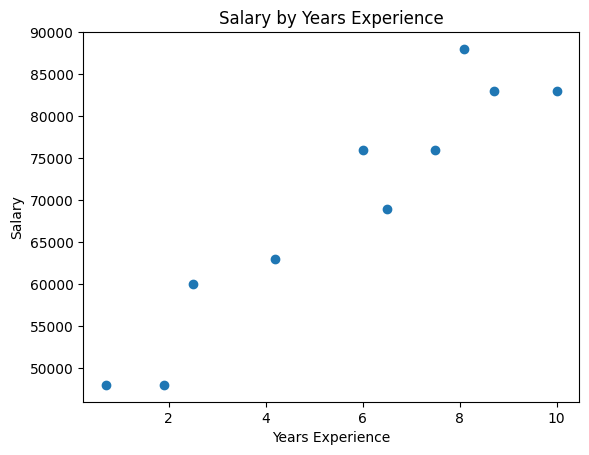

In [15]:
import matplotlib.pyplot as plt

# 提取薪资和工作年限
salaries = [s for s, t in salaries_and_tenures]
tenures = [t for s, t in salaries_and_tenures]

# 创建散点图
plt.scatter(tenures, salaries)

# 设置图表标题和标签
plt.title("Salary by Years Experience")
plt.xlabel("Years Experience")
plt.ylabel("Salary")

# 显示图表
plt.show()

结果似乎是呈现线性的关系

#### 每个任期的平均工资工资

In [16]:
# 键是工作年限，值是相应工资的列表
salary_by_tenure = defaultdict(list)

for salary, tenure in salaries_and_tenures:
    salary_by_tenure[tenure].append(salary)

# 键是工作年限，值是该年限对应的平均工资
average_salary_by_tenure = {
    tenure: sum(salaries) / len(salaries)
    for tenure, salaries in salary_by_tenure.items()
}

average_salary_by_tenure

{8.7: 83000.0,
 8.1: 88000.0,
 0.7: 48000.0,
 6: 76000.0,
 6.5: 69000.0,
 7.5: 76000.0,
 2.5: 60000.0,
 10: 83000.0,
 1.9: 48000.0,
 4.2: 63000.0}

似乎结果并没有说服力，观察数据会发现，任意两个用户的工作年限都不同

#### 分组的平均工资

In [17]:
def tenure_bucket(tenure):
    if tenure < 2:
        return "less than two"
    elif tenure < 5:
        return "between two and five"
    else:
        return "more than five"

In [18]:
# 键是工作年限分的组，值是相应工资的列表
salary_by_tenure_bucket = defaultdict(list)

for salary, tenure in salaries_and_tenures:
    bucket = tenure_bucket(tenure)
    salary_by_tenure_bucket[bucket].append(salary)

# 键是工作年限分的组，值是该组对应的平均工资
average_salary_by_bucket = {
    tenure_bucket: sum(salaries) / len(salaries)
    for tenure_bucket, salaries in salary_by_tenure_bucket.items()
}

average_salary_by_bucket

{'more than five': 79166.66666666667,
 'less than two': 48000.0,
 'between two and five': 61500.0}

### 付费账户

某个工作经验和是否付费的关系如下所示

| 工作经验 | 是否付费 | 
|---------|---------|
| 0.7 | paid |
| 1.9 | unpaid |
| 2.5 | paid |
| 4.2 | unpaid |
| 6.0 | unpaid |
| 6.5 | unpaid |
| 7.5 | paid |
| 8.1 | unpaid |
| 8.7 | paid |
| 10.0 | paid |

In [19]:
def predict_paid_or_unpaid(years_experience):
  if years_experience < 3.0:
    return "paid"
  elif years_experience < 8.5:
    return "unpaid"
  else:
    return "paid"

### 感兴趣的主题 （词频统计）

#### 初始数据

In [20]:
interests = [
    (0, "Hadoop"), (0, "Big Data"), (0, "HBase"), (0, "Java"),
    (0, "Spark"), (0, "Storm"), (0, "Cassandra"),
    (1, "NoSQL"), (1, "MongoDB"), (1, "Cassandra"), (1, "HBase"),
    (1, "Postgres"), (2, "Python"), (2, "scikit-learn"), (2, "scipy"),
    (2, "numpy"), (2, "statsmodels"), (2, "pandas"), (3, "R"), (3, "Python"),
    (3, "statistics"), (3, "regression"), (3, "probability"),
    (4, "machine learning"), (4, "regression"), (4, "decision trees"),
    (4, "libsvm"), (5, "Python"), (5, "R"), (5, "Java"), (5, "C++"),
    (5, "Haskell"), (5, "programming languages"), (6, "statistics"),
    (6, "probability"), (6, "mathematics"), (6, "theory"),
    (7, "machine learning"), (7, "scikit-learn"), (7, "Mahout"),
    (7, "neural networks"), (8, "neural networks"), (8, "deep learning"),
    (8, "Big Data"), (8, "artificial intelligence"), (9, "Hadoop"),
    (9, "Java"), (9, "MapReduce"), (9, "Big Data")
]

找到最受欢迎的兴趣的一种简单的方法就是计算兴趣词汇的个数：

1. 将每个字符小写
2. 将其切分为单词
3. 计数

In [21]:
words_and_counts = Counter(word
                           for user, interest in interests
                           for word in interest.lower().split())

for word, count in words_and_counts.most_common():
    if count > 1:
        print(word, count)

big 3
data 3
java 3
python 3
learning 3
hadoop 2
hbase 2
cassandra 2
scikit-learn 2
r 2
statistics 2
regression 2
probability 2
machine 2
neural 2
networks 2


### 数据思维案例：求Pi值

#### 蒙特卡洛法 模拟求Pi值

In [22]:
import random

def monte_carlo_pi(num_samples):
    inside_circle = 0

    for _ in range(num_samples):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        distance = x**2 + y**2

        if distance <= 1:
            inside_circle += 1

    estimated_pi = (inside_circle / num_samples) * 4
    return estimated_pi

num_samples = 100000000  # 设置模拟点的数量
pi_estimate = monte_carlo_pi(num_samples)
print(f"Estimated pi: {pi_estimate}")

Estimated pi: 3.1414298


#### 利用 matplotlib 展示

Estimated pi: 3.142248


/Users/huangwenrui/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


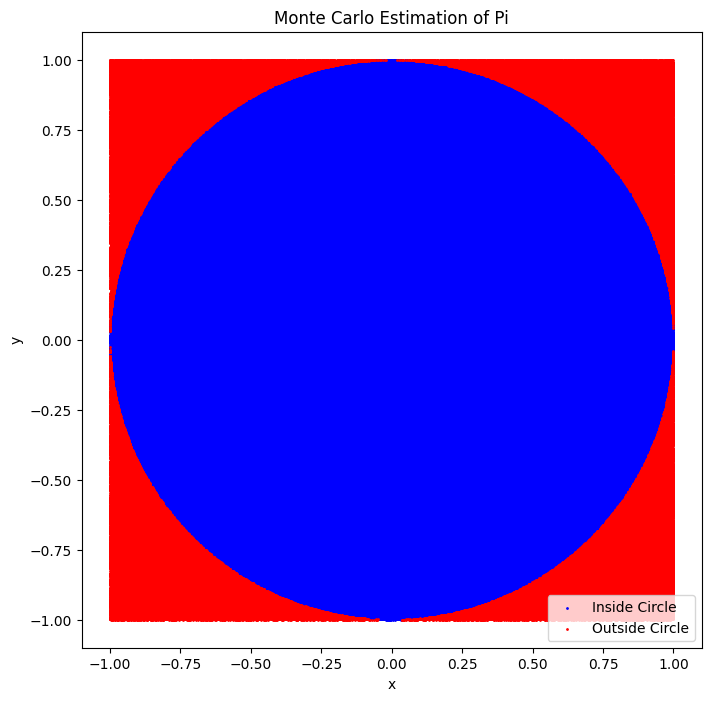

In [23]:
import random
import matplotlib.pyplot as plt


def monte_carlo_pi(num_samples):
    inside_circle = 0
    x_inside = []
    y_inside = []
    x_outside = []
    y_outside = []

    for _ in range(num_samples):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        distance = x**2 + y**2

        if distance <= 1:
            inside_circle += 1
            x_inside.append(x)
            y_inside.append(y)
        else:
            x_outside.append(x)
            y_outside.append(y)

    estimated_pi = (inside_circle / num_samples) * 4
    return estimated_pi, x_inside, y_inside, x_outside, y_outside


def plot_monte_carlo_pi(x_inside, y_inside, x_outside, y_outside):
    plt.figure(figsize=(8, 8))
    plt.scatter(x_inside, y_inside, color='blue', s=1, label='Inside Circle')
    plt.scatter(x_outside, y_outside, color='red', s=1, label='Outside Circle')

    plt.title('Monte Carlo Estimation of Pi')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

    plt.show()



num_samples = 1000000  # 设置模拟点的数量
pi_estimate, x_inside, y_inside, x_outside, y_outside = monte_carlo_pi(
        num_samples)

print(f"Estimated pi: {pi_estimate}")

plot_monte_carlo_pi(x_inside, y_inside, x_outside, y_outside)

### 扩展库实践

#### Numpy

NumPy(Numerical Python) 是 Python 语言的一个扩展程序库，支持大量的维度数组与矩阵运算，此外也针对数组运算提供大量的数学函数库。

NumPy 的前身 Numeric 最早是由 Jim Hugunin 与其它协作者共同开发，2005 年，Travis Oliphant 在 Numeric 中结合了另一个同性质的程序库 Numarray 的特色，并加入了其它扩展而开发了 NumPy。NumPy 为开放源代码并且由许多协作者共同维护开发。

NumPy 是一个运行速度非常快的数学库，主要用于数组计算，包含：

- 一个强大的N维数组对象 ndarray
- 广播功能函数
- 整合 C/C++/Fortran 代码的工具
- 线性代数、傅里叶变换、随机数生成等功能

`pip install numpy` 安装扩展库

In [24]:
import numpy as np

##### 创建 NumPy 数组

创建一维数组

In [25]:
# 通过列表创建一维数组
arr_1d = np.array([1, 2, 3, 4, 5])
print(arr_1d)

[1 2 3 4 5]


创建二维数组

In [26]:
# 通过嵌套列表创建二维数组
arr_2d = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(arr_2d)

[[1 2 3]
 [4 5 6]
 [7 8 9]]


##### 数组属性

In [27]:
# 数组维度
print("数组维度:", arr_2d.ndim)

# 数组形状
print("数组形状:", arr_2d.shape)

# 数组元素总个数
print("数组元素总个数:", arr_2d.size)

# 数组元素数据类型
print("数组元素数据类型:", arr_2d.dtype)

数组维度: 2
数组形状: (3, 3)
数组元素总个数: 9
数组元素数据类型: int64


##### 数组操作

数学运算

In [28]:
# 数组加法
arr_sum = arr_1d + 10
print("数组加法:", arr_sum)

# 数组乘法
arr_prod = arr_1d * 2
print("数组乘法:", arr_prod)

数组加法: [11 12 13 14 15]
数组乘法: [ 2  4  6  8 10]


索引和切片

In [29]:
# 获取数组元素
print("第一个元素:", arr_1d[0])

# 切片操作
print("前三个元素:", arr_1d[:3])

第一个元素: 1
前三个元素: [1 2 3]


转置

In [30]:
arr = np.array([[1, 2, 3], [4, 5, 6]])
arr_transposed = arr.T
print("转置前的数组:\n", arr)
print("转置后的数组:\n", arr_transposed)

转置前的数组:
 [[1 2 3]
 [4 5 6]]
转置后的数组:
 [[1 4]
 [2 5]
 [3 6]]


##### 线性代数

矩阵乘法

In [31]:
matrix_a = np.array([[1, 2], [3, 4]])
matrix_b = np.array([[5, 6], [7, 8]])
matrix_product = np.dot(matrix_a, matrix_b)
print("矩阵乘法结果:\n", matrix_product)

矩阵乘法结果:
 [[19 22]
 [43 50]]


行列式与逆矩阵

In [32]:
# 行列式
det = np.linalg.det(matrix_a)
print("矩阵行列式:", det)

# 逆矩阵
inv_matrix_a = np.linalg.inv(matrix_a)
print("矩阵的逆:\n", inv_matrix_a)

矩阵行列式: -2.0000000000000004
矩阵的逆:
 [[-2.   1. ]
 [ 1.5 -0.5]]


##### NumPy 函数

linspace

In [33]:
# 在指定范围内生成等间隔的数字
arr_linspace = np.linspace(0, 1, 5)
print("linspace生成的数组:", arr_linspace)

linspace生成的数组: [0.   0.25 0.5  0.75 1.  ]


zores 和 ones

In [34]:
# 创建全零数组
arr_zeros = np.zeros((2, 3))
print("全零数组:", arr_zeros)

# 创建全一数组
arr_ones = np.ones((3, 2))
print("全一数组:", arr_ones)

全零数组: [[0. 0. 0.]
 [0. 0. 0.]]
全一数组: [[1. 1.]
 [1. 1.]
 [1. 1.]]


#### Pandas

![image](https://github.com/X-lab2017/dase-2023-autumn/assets/50283262/fe41a4e6-b509-4a7b-9643-4713338422b2)

Pandas 是 Python 语言的一个扩展程序库，用于数据分析。Pandas 是一个开放源码、BSD 许可的库，提供高性能、易于使用的数据结构和数据分析工具。Pandas 名字衍生自术语 "panel data"（面板数据）和 "Python data analysis"（Python 数据分析）。Pandas 一个强大的分析结构化数据的工具集，基础是 Numpy（提供高性能的矩阵运算）。Pandas 可以从各种文件格式比如 CSV、JSON、SQL、Microsoft Excel 导入数据。Pandas 可以对各种数据进行运算操作，比如归并、再成形、选择，还有数据清洗和数据加工特征。Pandas 广泛应用在学术、金融、统计学等各个数据分析领域。

`pip install pandas` 安装扩展库

In [35]:
import pandas as pd

##### 创建 Pandas Series

通过列表创建 Series

In [36]:
# 创建一个简单的 Series
data = [1, 2, 3, 4, 5]
series = pd.Series(data)
print(series)

0    1
1    2
2    3
3    4
4    5
dtype: int64


制定索引

In [37]:
# 指定索引的 Series
data = [1, 2, 3, 4, 5]
index = ['a', 'b', 'c', 'd', 'e']
series = pd.Series(data, index=index)
print(series)

a    1
b    2
c    3
d    4
e    5
dtype: int64


##### 创建 Pandas DataFrame

通过字典创建 DataFrame

In [38]:
# 创建一个简单的 DataFrame
data = {'Name': ['Alice', 'Bob', 'Charlie'],
        'Age': [25, 30, 35],
        'City': ['New York', 'San Francisco', 'Los Angeles']}
df = pd.DataFrame(data)
df

,Name,Age,City
0,Alice,25,New York
1,Bob,30,San Francisco
2,Charlie,35,Los Angeles


指定行和列索引

In [39]:
# 指定行和列索引的 DataFrame
data = {'Name': ['Alice', 'Bob', 'Charlie'],
        'Age': [25, 30, 35],
        'City': ['New York', 'San Francisco', 'Los Angeles']}
index = ['person_1', 'person_2', 'person_3']
df = pd.DataFrame(data, index=index)
df

,Name,Age,City
person_1,Alice,25,New York
person_2,Bob,30,San Francisco
person_3,Charlie,35,Los Angeles


##### 数据检索和操作

获取列

In [40]:
# 获取特定列
name_column = df['Name']
print(name_column)

person_1      Alice
person_2        Bob
person_3    Charlie
Name: Name, dtype: object


筛选数据

In [41]:
# 根据条件筛选数据
young_people = df[df['Age'] < 30]
print("年龄小于30的人:\n", young_people)

年龄小于30的人:
            Name  Age      City
person_1  Alice   25  New York


##### 统计信息和摘要

In [42]:
# 显示统计信息和摘要
summary = df.describe()
print("数据摘要:\n", summary)

数据摘要:
         Age
count   3.0
mean   30.0
std     5.0
min    25.0
25%    27.5
50%    30.0
75%    32.5
max    35.0


#### Matplotlib

`pip install matplotlib` 安装扩展库

##### 线图

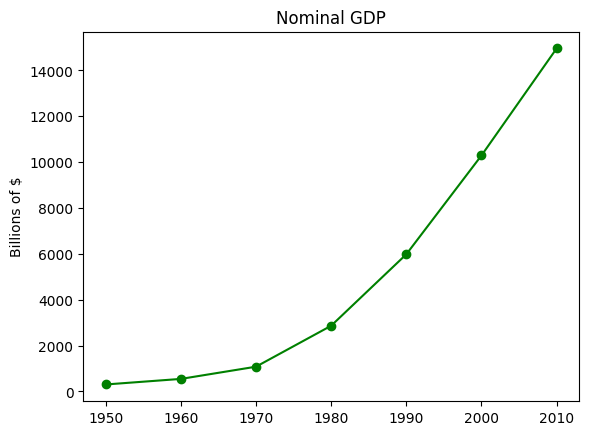

In [43]:
from matplotlib import pyplot as plt

years = [1950, 1960, 1970, 1980, 1990, 2000, 2010]
gdp = [300.2, 543.3, 1075.9, 2862.5, 5979.6, 10289.7, 14958.3]

# 创建一个线图，x轴是年份，y轴是gdp
plt.plot(years, gdp, color='green', marker='o', linestyle='solid')

# 添加一个标题
plt.title("Nominal GDP")

# 为y轴添加标记
plt.ylabel("Billions of $")
plt.show()

##### 条形图

当需要展示某些离散项目集合中的数量是如何变化时，条形图是一个不错的选择。

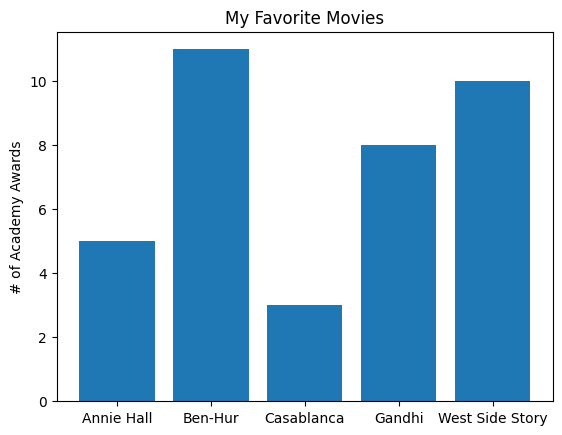

In [44]:
movies = ["Annie Hall", "Ben-Hur", "Casablanca", "Gandhi", "West Side Story"]
num_oscars = [5, 11, 3, 8, 10]

# plot bars with left x-coordinates [0, 1, 2, 3, 4], heights [num_oscars]
plt.bar(range(len(movies)), num_oscars)

plt.title("My Favorite Movies")     # add a title
plt.ylabel("# of Academy Awards")   # label the y-axis

# label x-axis with movie names at bar centers
plt.xticks(range(len(movies)), movies)

plt.show()

条形图也可以用来绘制大量数值直方图，以便直观地探索值的分布情况。

Text(0.5, 1.0, 'Distribution of Exam 1 Grades')

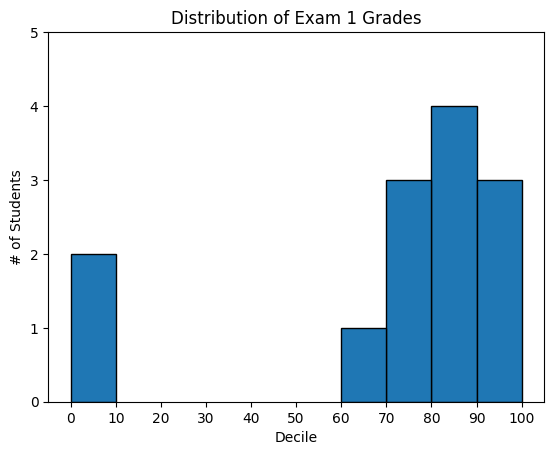

In [45]:
from collections import Counter

grades = [83, 95, 91, 87, 70, 0, 85, 82, 100, 67, 73, 77, 0]

# Bucket grades by decile, but put 100 in with the 90s
histogram = Counter(min(grade // 10 * 10, 90) for grade in grades)

plt.bar([x + 5 for x in histogram.keys()],  # Shift bars right by 5
        histogram.values(),                 # Give each bar its correct height
        10,                                 # Give each bar a width of 8
        edgecolor=(0, 0, 0))                # Black edges for each bar

plt.axis([-5, 105, 0, 5])                  # x-axis from -5 to 105,
# y-axis from 0 to 5

plt.xticks([10 * i for i in range(11)])    # x-axis labels at 0, 10, ..., 100
plt.xlabel("Decile")
plt.ylabel("# of Students")
plt.title("Distribution of Exam 1 Grades")
# plt.show()

##### 散点图

散点图是可视化两个成对数据集之间关系的不错的选择。

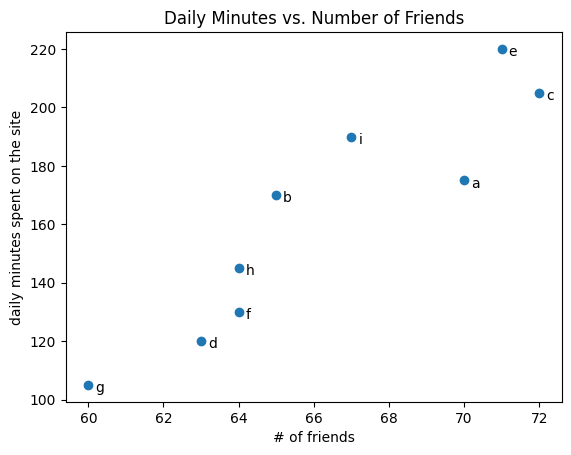

In [46]:
friends = [70,  65,  72,  63,  71,  64,  60,  64,  67]
minutes = [175, 170, 205, 120, 220, 130, 105, 145, 190]
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']

plt.scatter(friends, minutes)

# label each point
for label, friend_count, minute_count in zip(labels, friends, minutes):
    plt.annotate(label,
                 # Put the label with its point
                 xy=(friend_count, minute_count),
                 xytext=(5, -5),                  # but slightly offset
                 textcoords='offset points')

plt.title("Daily Minutes vs. Number of Friends")
plt.xlabel("# of friends")
plt.ylabel("daily minutes spent on the site")
plt.show()